In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

tabular = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv', index_col = 'row_id')
submission = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col = 'row-col')

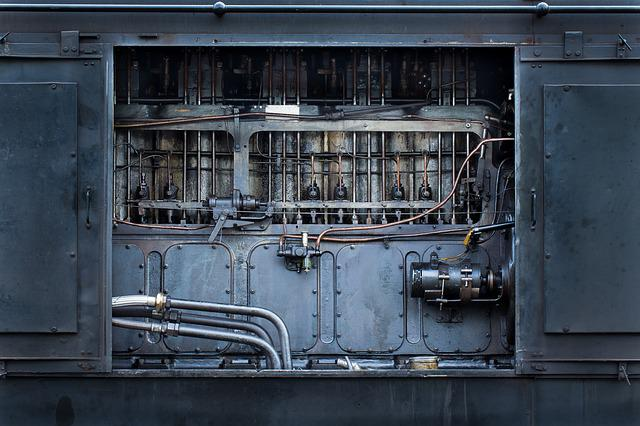

# Introduction

This notebook present an fast-running linear algorithm for imputation.

# Preprocessing

### Data reducing

In [ ]:
tabular.info()

In [ ]:
col_list = tabular.columns

for i in col_list: # For all the name of columns
    if(i == 'row_id') : continue
    elif(tabular[i].dtype == 'int64' ): # if i_th data type is integer...
        tabular[i] = np.int16(tabular[i]) 
    else : # if i_th data type is float...
        tabular[i] = np.float16(tabular[i])

### Data split

In [ ]:
tabular_group_four = tabular[col_list[65:]].copy() # F_4_.*
tabular_group_one_two_three = tabular[col_list[:65]].copy() # others

# Impute

You can see plots in other notebooks(I'll update later). There are two important points in this data. 

1) All continuous variables follow Gaussian. 

2) Only variables in F_4_. group correlated each other.

Therefore, F_4_. variables can be expressed as Multivariate normal distribution. So I thought linear regression will be quite effective to impute data. 

### Simple imputation with F_(1,3)_. variables

All variables in F_(1,3)_.. groups are independent because zero correlation between two normal random variables means they're independent. Thus, imputation with mean is appropriate.

In [ ]:
imp = SimpleImputer(
        missing_values=np.nan,
        strategy='mean',
        )
tabular_group_one_two_three[:] = imp.fit_transform(tabular_group_one_two_three)

### regression imputation with F_4_. variables

For simple, we're going to impute observations have two more na with mean. For all observations that has a single na, we're going to impute them with linear regression model. We need models as many as the number of variables.

In [ ]:
class MyRegressionImputationMachine:
    def __init__(self, X):
        self.X = X
        self.col_list = X.columns
        self.n = X.shape[0]
        self.d = X.shape[1]
    
    # extract index that has na value
    def na_col_calculate(self):
        self.na_index = [[] for i in range(self.d)]
        na_mat = self.X.isna()
        for j in range(self.d):
            for i in range(self.n):
                if (na_mat[self.col_list[j]][i]):
                    self.na_index[j].append(i)
    
    # prepare data has no na
    def prepare_clean_data(self):
        self.clean_X = self.X.dropna().sample(1000)
        
    # For observations that has more than two na, impute it as mean.
    def mean_impute_more_than_two(self):
        mu = [0 for i in range(self.d)]
        for i in range(self.d):
            mu[i] = np.mean(self.clean_X.iloc()[:,i])
        
        sum_vec = self.X.isna().sum(axis = 1)
        for i in range(self.n):
            if(sum_vec[i] >= 2):
                for j in range(self.d):
                    if(np.isnan(self.X.iloc()[i,j])):
                        self.X.iloc()[i,j] = mu[j]
        
    # fill na value 
    def fill_na(self, imputed_vec, col):
        j = 0 
        for i in self.na_index[col]:
            self.X.iloc()[i,col] = imputed_vec[j]
            j += 1
    
    # fit linear regression and impute
    def regression_impute(self):
        for i in range(self.d):
            model = LinearRegression()
            model.fit(self.clean_X.drop(columns = self.col_list[i]), self.clean_X.iloc()[:,i])
            pred = model.predict(self.X.iloc()[self.na_index[i]].drop(columns = self.col_list[i]))
            self.fill_na(pred, i)
        return self.X

In [ ]:
# Linear regression imputation

my_imp = MyRegressionImputationMachine(tabular_group_four)
my_imp.prepare_clean_data()
my_imp.mean_impute_more_than_two()
my_imp.na_col_calculate()
tabular_group_four = my_imp.regression_impute()

In [ ]:
# put the divided data back together
result = tabular_group_one_two_three.join(tabular_group_four)

In [ ]:
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i, 'value'] = result.loc[row, col]

submission.to_csv('result.csv')

# Conclusion

As I said, I think linear regression is enough to impute as all continuous variables follow Gaussian. However, the algorithm I made isn't good because I didn't optimize it and I applied it only observations with a single na. It will outcome better accuracy if it's updated later.